In [ ]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.image as mpimg
from keras.preprocessing import image
import datetime
%matplotlib inline


from sklearn.model_selection import train_test_split

# Importing data

In [ ]:
datapath = "/content/drive/MyDrive/Drowsiness detection/train"
#The shared link is https://drive.google.com/drive/folders/1hq7y23bLH8SsmyhmaIjTZiXwz4oRU9kj?usp=sharing

In [ ]:
#creating empty lists where we will match the class of image with its code ("0" for the closed eye, "1" for the open eye)
X = []
Y = []

for i in tqdm(glob('/content/drive/MyDrive/Drowsiness detection/train/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('/content/drive/MyDrive/Drowsiness detection/train/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(0)    

100%|██████████| 2000/2000 [00:03<00:00, 548.14it/s]


# Exploratory data analysis

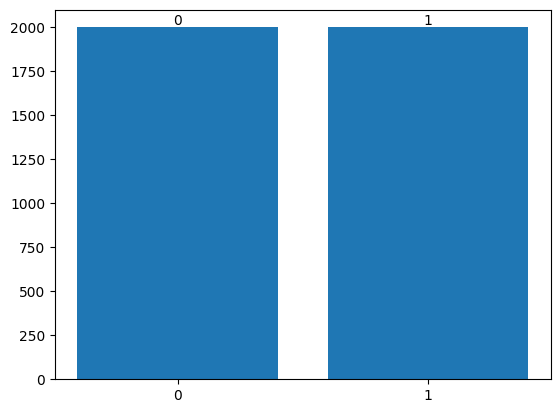

In [ ]:
#checking balance of classes
Y_unique = list(set(Y))
counts = [Y.count(value) for value in Y_unique]
barcontainer = plt.bar(range(len(Y_unique)),counts)
plt.bar_label(barcontainer,Y_unique,label_type='edge')
plt.xticks([0,1])
plt.show()

Image dimensions: (86, 86)


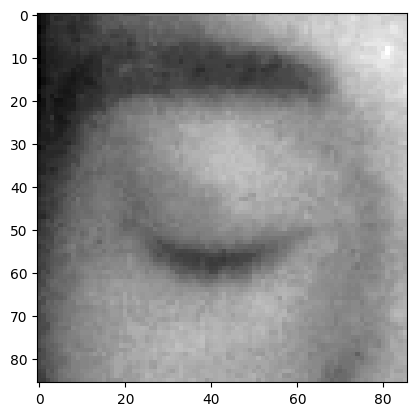

In [ ]:
# Read in the image
image = mpimg.imread('/content/drive/MyDrive/Drowsiness detection/train/Closed_Eyes/s0001_00001_0_0_0_0_0_01.png')

# Print out the image dimensions
print('Image dimensions:', image.shape)
plt.imshow(image, cmap="gray")

The dataset is balanced. It has 2 classes with 2000 images in each of them.

# Building a CNN model

In [ ]:
X = np.array(X)
X = X/255.0
Y = np.array(Y)

In [ ]:
X = np.expand_dims(X,-1)

We will split the dataset into 3 parts: 70% for training the model, 15% - for the model validation and 15% for testing the model.

In [ ]:
X_train, X_test1, Y_train, Y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test1, Y_test1, test_size=0.5, random_state=42)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Experiment 1 

In [ ]:
model = tf.keras.models.Sequential([
      Input(shape=(64, 64, 1)),

      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu'),
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Flatten(),
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),

      Dense(units = 1, activation = 'sigmoid')
  ])

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 32)        25600     
                                                                 
 batch_normalization_4 (Batc  (None, 56, 56, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 64)       

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3)

In [ ]:
chckpntng_pth = "best_checkpoint"
chckpntng = tf.keras.callbacks.ModelCheckpoint(
    filepath = chckpntng_pth,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)


In [ ]:
history_ds = model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid],  epochs=30, batch_size=32, callbacks=[early_stopping, chckpntng])

Epoch 1/30
86/88 [============================>.] - ETA: 0s - loss: 0.7111 - accuracy: 0.9851
Epoch 1: val_loss did not improve from -64.29748
88/88 [==============================] - 2s 18ms/step - loss: 0.6989 - accuracy: 0.9854 - val_loss: 26.3574 - val_accuracy: 0.6433
Epoch 2/30
85/88 [===========================>..] - ETA: 0s - loss: 0.1044 - accuracy: 0.9930
Epoch 2: val_loss did not improve from -64.29748
88/88 [==============================] - 1s 15ms/step - loss: 0.1014 - accuracy: 0.9932 - val_loss: 3.4761 - val_accuracy: 0.8550
Epoch 3/30
85/88 [===========================>..] - ETA: 0s - loss: 0.1754 - accuracy: 0.9934
Epoch 3: val_loss did not improve from -64.29748
88/88 [==============================] - 1s 15ms/step - loss: 0.1704 - accuracy: 0.9936 - val_loss: 0.0869 - val_accuracy: 0.9950
Epoch 4/30
85/88 [===========================>..] - ETA: 0s - loss: 0.1703 - accuracy: 0.9930
Epoch 4: val_loss did not improve from -64.29748
88/88 [==============================

In [ ]:
model.evaluate(X_test, Y_test)

19/19 [==============================] - 0s 5ms/step - loss: 2.1016e-05 - accuracy: 1.0000


[2.1016499886172824e-05, 1.0]

In [ ]:
model.save('/content/drive/MyDrive/Drowsiness detection/First model',save_format = 'tf')

## Experiment 2 (we ran out of RAM at the second experiment at the train-test split step:(((.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
#creating empty lists where we will match the class of image with its code ("0" for the closed eye, "1" for the open eye)
X_new = []
Y_new = []

for i in tqdm(glob('/content/drive/MyDrive/Drowsiness detection/train/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((224,224)).convert("RGB"))
    X_new.append(temp)
    Y_new.append(1)
    
for i in tqdm(glob('/content/drive/MyDrive/Drowsiness detection/train/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((224,224)).convert("RGB"))
    X_new.append(temp)
    Y_new.append(0)    

100%|██████████| 2000/2000 [00:37<00:00, 52.97it/s] 


In [ ]:
X_new = np.array(X_new)
X_new = X_new/255.0
Y_new = np.array(Y_new)

In [ ]:
X_new = np.expand_dims(X_new,-1)

In [ ]:
X_new.shape

(4000, 224, 224, 3)

In [ ]:
pre_X_train, pre_X_test1, pre_Y_train, pre_Y_test1 = train_test_split(X_new, Y_new, test_size=0.3, random_state=42)
pre_X_test, pre_X_valid, pre_Y_test, pre_Y_valid = train_test_split(pre_X_test1, pre_Y_test1, test_size=0.5, random_state=42)

In [ ]:
pre_model = ResNet50(weights='imagenet')

In [ ]:
pre_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
pre_chckpntng_pth = "pre_best_checkpoint"
pre_chckpntng = tf.keras.callbacks.ModelCheckpoint(
    filepath = pre_chckpntng_pth,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)


In [ ]:
pre_history_ds = pre_model.fit(pre_X_train, pre_Y_train, validation_data=[pre_X_valid, pre_Y_valid],  epochs=5, batch_size=32, callbacks=[early_stopping, pre_chckpntng])

In [ ]:
pre_model.predict(pre_X_test)

125/125 [==============================] - 21s 82ms/step


array([[1.6535734e-04, 3.1270349e-04, 5.8787224e-05, ..., 1.4059664e-05,
        1.4077408e-04, 6.4283918e-04],
       [1.7094711e-04, 3.2842677e-04, 6.1139537e-05, ..., 1.4739182e-05,
        1.4495825e-04, 6.5828406e-04],
       [1.6691817e-04, 3.1210078e-04, 5.9071648e-05, ..., 1.4213890e-05,
        1.4130432e-04, 6.3425448e-04],
       ...,
       [1.7032678e-04, 3.2948173e-04, 6.0848844e-05, ..., 1.4697523e-05,
        1.4465244e-04, 6.5868103e-04],
       [1.6994664e-04, 3.2889686e-04, 6.0832841e-05, ..., 1.4701682e-05,
        1.4467054e-04, 6.5576559e-04],
       [1.7071434e-04, 3.2775899e-04, 6.0083959e-05, ..., 1.4751531e-05,
        1.4421980e-04, 6.5116148e-04]], dtype=float32)

In [ ]:
pre_model.save('/content/drive/MyDrive/Drowsiness detection/Second model',save_format = 'tf')